In [20]:
import tensorflow as tf
# Define Constants with float32 Data Type
import numpy as np
import matplotlib.pyplot as plt

# Initial Conditions
T0 = np.float32(100000.0)
I0 = np.float32(0.0)
L0 = np.float32(0.0)
V0 = np.float32(200.0)

# Parameters
d = np.float32(0.01)
beta = np.float32(0.0000002)
f = np.float32(0.001)
a = np.float32(0.2)
delta_I = np.float32(1.0)
delta_L = np.float32(0.0039)
c = np.float32(23.0)
p = np.float32(4000.0)
lambda_param = d * T0  # λ
Omega = np.float32(1.0)

In [21]:
# Example: Increasing layers and neurons
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(64, activation='relu')
        self.dense2 = tf.keras.layers.Dense(64, activation='relu')
        self.dense3 = tf.keras.layers.Dense(64, activation='relu')
        self.dense4 = tf.keras.layers.Dense(64, activation='relu')
        self.output_layer = tf.keras.layers.Dense(4)
    
    def call(self, t):
        t = self.dense1(t)
        t = self.dense2(t)
        t = self.dense3(t)
        t = self.dense4(t)
        return self.output_layer(t)

In [22]:
# Modified loss function with weighting
def loss_fn(model, t):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t)
        pinn_pred = model(t)
        T, I, L, V = tf.split(pinn_pred, 4, axis=1)
        
        # First derivatives
        dT_dt = tape.gradient(T, t)
        dI_dt = tape.gradient(I, t)
        dL_dt = tape.gradient(L, t)
        dV_dt = tape.gradient(V, t)
        
        # Residuals
        res_T = dT_dt - (lambda_param - d * T - Omega * beta * V * T)
        res_I = dI_dt - ((1 - f) * Omega * beta * V * T + a * L - delta_I * I)
        res_L = dL_dt - (f * Omega * beta * V * T - a * L - delta_L * L)
        res_V = dV_dt - (Omega * p * I - c * V)
        
        # Initial conditions
        init_loss_T = tf.square(T[0] - T0)
        init_loss_I = tf.square(I[0] - I0)
        init_loss_L = tf.square(L[0] - L0)
        init_loss_V = tf.square(V[0] - V0)
        
        # Weighting factors
        loss = (
            tf.reduce_mean(tf.square(res_T)) +
            tf.reduce_mean(tf.square(res_I)) +
            tf.reduce_mean(tf.square(res_L)) +
            tf.reduce_mean(tf.square(res_V)) +
            1000 * (init_loss_T + init_loss_I + init_loss_L + init_loss_V)
        )
    return loss

In [23]:
def train(model, t, epochs, optimizer):
    for i in range(epochs):
        with tf.GradientTape() as tape:
            loss = loss_fn(model, t)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        if i % 1000 == 0:
            print(f'Epoch {i}, Loss: {loss.numpy()}')

In [24]:
model = PINN()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [25]:
# Increasing the number of training points
t = tf.convert_to_tensor(np.linspace(0, 100, 2000).reshape(-1, 1), dtype=tf.float32)

In [26]:
train(model, t, epochs=15000, optimizer=optimizer)


Epoch 0, Loss: [1.0001184e+13]
Epoch 1000, Loss: [9226432.]
Epoch 2000, Loss: [8507290.]
Epoch 3000, Loss: [8129946.]
Epoch 4000, Loss: [12272619.]
Epoch 5000, Loss: [8883125.]
Epoch 6000, Loss: [12832463.]
Epoch 7000, Loss: [10971582.]
Epoch 8000, Loss: [7265880.]
Epoch 9000, Loss: [12013174.]
Epoch 10000, Loss: [7681846.]
Epoch 11000, Loss: [6552923.]
Epoch 12000, Loss: [10192143.]
Epoch 13000, Loss: [39603812.]
Epoch 14000, Loss: [10353151.]


In [27]:
t_test = np.linspace(0, 100, 1000)[:, None]

T_pred, I_pred, L_pred, V_pred = model(t_test).numpy().T


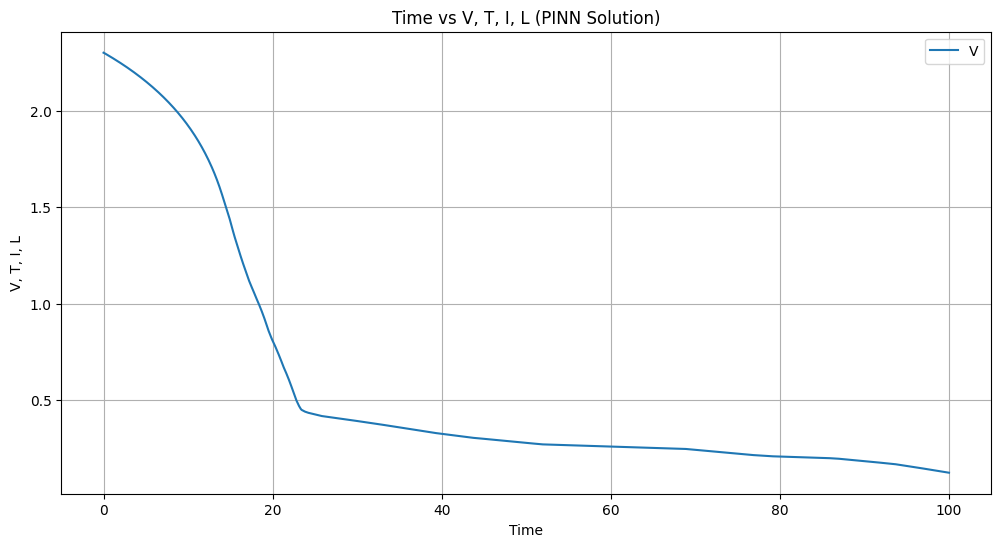

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(t_test, np.log10(V_pred), label='V')
plt.xlabel("Time")
plt.ylabel("V, T, I, L")
plt.title("Time vs V, T, I, L (PINN Solution)")
plt.legend()
plt.grid(True)
plt.show()

C:\Users\sebas\AppData\Local\Temp\ipykernel_13080\2763613546.py:30: RuntimeWarning: invalid value encountered in log10
  plt.plot(t_test, np.log10(V_pred), color="red", label='PINN_V')


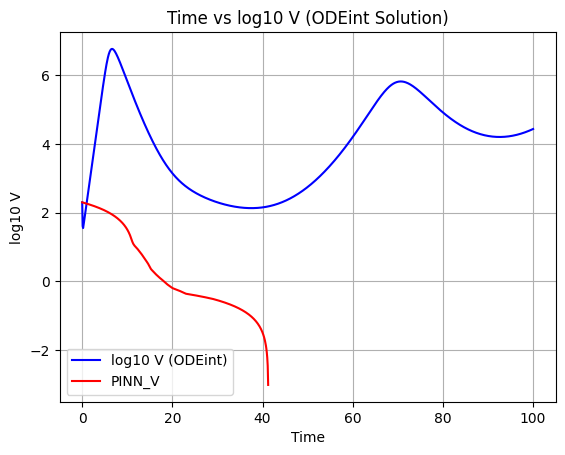

In [28]:
from scipy.integrate import odeint


# Define the system of ODEs
def system(Y, t):
    T, I, L, V = Y
    dT_dt = lambda_param - d * T - Omega * beta * V * T
    dI_dt = (1 - f) * Omega * beta * V * T + a * L - delta_I * I
    dL_dt = f * Omega * beta * V * T - a * L - delta_L * L
    dV_dt = Omega * p * I - c * V
    return [dT_dt, dI_dt, dL_dt, dV_dt]

# Initial conditions
Y0 = [T0, I0, L0, V0]

t = np.linspace(0, 100, 1000)

# Solve ODEs
solution = odeint(system, Y0, t)
T, I, L, V = solution.T

# Plotting the results
# Small constant to prevent log10(0)
epsilon = 1e-5

plt.plot(t, np.log10(V + epsilon), color="blue", label="log10 V (ODEint)")
plt.xlabel("Time")
plt.ylabel("log10 V")
plt.title("Time vs log10 V (ODEint Solution)")
plt.plot(t_test, np.log10(V_pred), color="red", label='PINN_V')
plt.legend()
plt.grid(True)
plt.show()

# Compare with Runge-Kutta Solution if available
# Assuming T_rk, I_rk, L_rk, V_rk are obtained from Runge-Kutta
# Uncomment the following lines if Runge-Kutta results are available
